# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [2]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    img_transforms = transforms.Compose([transforms.Resize(image_size),
                                        transforms.ToTensor()])
    
    img_datasets = datasets.ImageFolder(data_dir, transform = img_transforms)
    
    return torch.utils.data.DataLoader(img_datasets, batch_size = batch_size, shuffle=True)


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

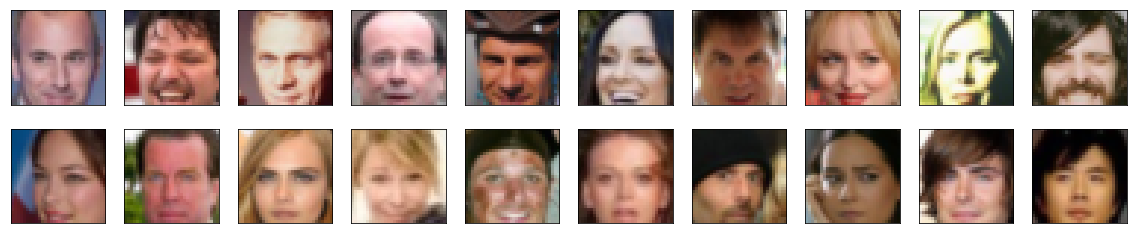

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    
    return x * (max - min) + min


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.6078)
Max:  tensor(0.7804)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    #Create a CNN layer with optional batch normalization
    layers = []
    
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim * 2, 4)
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, 4)
        
        #Connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        
        #Flatten 
        x = x.view(-1, self.conv_dim*4*4*4)
        
        #output
        out = self.fc(x)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    #Transpose convolution layer with optional batch normalization
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        #Fully connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        #Transpose layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        #conv layers
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        
        out = F.tanh(self.t_conv3(x))
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname.find('Conv')!=-1 or classname.find('Linear')!=-1:
        nn.init.normal_(m.weight.data, mean=0, std=0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
# Least square error loss
def real_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out - 1)**2)

def fake_loss(D_out):
    # how close is the produced output from being "false"?
    return torch.mean(D_out**2)

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [26]:
import torch.optim as optim

lr = 0.005
beta1 = 0.2
beta2 = 0.999
# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [27]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            #Discriminator loss with real images
            if train_on_gpu:
                real_images = real_images.cuda()
            d_optimizer.zero_grad()
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            #Generating fake images
            z = np.random.uniform(-1,1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
            #move z to gpu is available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            #discriminator losses on the fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            #Total loss and back propagation
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            #generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)   
            #Calculate the discriminator losses on fake images
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            
            #Backprop
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [28]:
# set number of epochs 
n_epochs = 40


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   40] | d_loss: 0.7034 | g_loss: 2.4627
Epoch [    1/   40] | d_loss: 0.6313 | g_loss: 0.2635
Epoch [    1/   40] | d_loss: 0.6420 | g_loss: 0.4413
Epoch [    1/   40] | d_loss: 0.6301 | g_loss: 0.3067
Epoch [    1/   40] | d_loss: 0.6025 | g_loss: 0.3182
Epoch [    1/   40] | d_loss: 0.5304 | g_loss: 0.2937
Epoch [    1/   40] | d_loss: 0.5141 | g_loss: 0.2226
Epoch [    1/   40] | d_loss: 0.5190 | g_loss: 0.2806
Epoch [    1/   40] | d_loss: 0.5312 | g_loss: 0.4420
Epoch [    1/   40] | d_loss: 0.5276 | g_loss: 0.2301
Epoch [    1/   40] | d_loss: 0.5173 | g_loss: 0.3603
Epoch [    1/   40] | d_loss: 0.5268 | g_loss: 0.2534
Epoch [    1/   40] | d_loss: 0.5368 | g_loss: 0.2345
Epoch [    1/   40] | d_loss: 0.5288 | g_loss: 0.3118
Epoch [    1/   40] | d_loss: 0.4929 | g_loss: 0.2827
Epoch [    1/   40] | d_loss: 0.5167 | g_loss: 0.3072
Epoch [    1/   40] | d_loss: 0.4755 | g_loss: 0.2552
Epoch [    1/   40] | d_loss: 0.5387 | g_loss: 0.3028
Epoch [    1/   40] | d_loss

Epoch [    6/   40] | d_loss: 0.4868 | g_loss: 0.2576
Epoch [    6/   40] | d_loss: 0.4993 | g_loss: 0.2645
Epoch [    6/   40] | d_loss: 0.5038 | g_loss: 0.2155
Epoch [    6/   40] | d_loss: 0.5059 | g_loss: 0.2485
Epoch [    6/   40] | d_loss: 0.5094 | g_loss: 0.2413
Epoch [    6/   40] | d_loss: 0.5039 | g_loss: 0.2420
Epoch [    6/   40] | d_loss: 0.5016 | g_loss: 0.2674
Epoch [    6/   40] | d_loss: 0.4992 | g_loss: 0.2436
Epoch [    6/   40] | d_loss: 0.4997 | g_loss: 0.2419
Epoch [    6/   40] | d_loss: 0.4984 | g_loss: 0.2392
Epoch [    6/   40] | d_loss: 0.4980 | g_loss: 0.2523
Epoch [    6/   40] | d_loss: 0.5023 | g_loss: 0.2548
Epoch [    6/   40] | d_loss: 0.4958 | g_loss: 0.2580
Epoch [    6/   40] | d_loss: 0.5001 | g_loss: 0.2527
Epoch [    6/   40] | d_loss: 0.4988 | g_loss: 0.2707
Epoch [    6/   40] | d_loss: 0.4962 | g_loss: 0.2514
Epoch [    6/   40] | d_loss: 0.5103 | g_loss: 0.3490
Epoch [    6/   40] | d_loss: 0.4987 | g_loss: 0.2468
Epoch [    6/   40] | d_loss

Epoch [   11/   40] | d_loss: 0.3836 | g_loss: 0.4245
Epoch [   11/   40] | d_loss: 0.4161 | g_loss: 0.2984
Epoch [   11/   40] | d_loss: 0.4308 | g_loss: 0.5255
Epoch [   11/   40] | d_loss: 0.4821 | g_loss: 0.4171
Epoch [   11/   40] | d_loss: 0.5975 | g_loss: 0.9695
Epoch [   11/   40] | d_loss: 0.4293 | g_loss: 0.5158
Epoch [   11/   40] | d_loss: 0.3419 | g_loss: 0.6098
Epoch [   11/   40] | d_loss: 0.4118 | g_loss: 0.3402
Epoch [   11/   40] | d_loss: 0.3742 | g_loss: 0.3407
Epoch [   11/   40] | d_loss: 0.4544 | g_loss: 0.4869
Epoch [   11/   40] | d_loss: 0.4041 | g_loss: 0.5001
Epoch [   11/   40] | d_loss: 0.4953 | g_loss: 0.6191
Epoch [   11/   40] | d_loss: 0.4533 | g_loss: 0.2514
Epoch [   11/   40] | d_loss: 0.4218 | g_loss: 0.5414
Epoch [   11/   40] | d_loss: 0.4500 | g_loss: 0.3567
Epoch [   12/   40] | d_loss: 0.4308 | g_loss: 0.3387
Epoch [   12/   40] | d_loss: 0.4044 | g_loss: 0.4784
Epoch [   12/   40] | d_loss: 0.4241 | g_loss: 0.4816
Epoch [   12/   40] | d_loss

Epoch [   16/   40] | d_loss: 0.4736 | g_loss: 0.7418
Epoch [   16/   40] | d_loss: 0.2899 | g_loss: 0.6245
Epoch [   16/   40] | d_loss: 0.3414 | g_loss: 0.4653
Epoch [   16/   40] | d_loss: 0.3385 | g_loss: 0.5546
Epoch [   16/   40] | d_loss: 0.3629 | g_loss: 0.9692
Epoch [   16/   40] | d_loss: 0.3185 | g_loss: 0.4166
Epoch [   16/   40] | d_loss: 0.6183 | g_loss: 0.1292
Epoch [   16/   40] | d_loss: 0.3434 | g_loss: 0.3888
Epoch [   17/   40] | d_loss: 0.3324 | g_loss: 0.6769
Epoch [   17/   40] | d_loss: 0.2741 | g_loss: 0.3376
Epoch [   17/   40] | d_loss: 0.3457 | g_loss: 0.6196
Epoch [   17/   40] | d_loss: 0.3484 | g_loss: 0.5091
Epoch [   17/   40] | d_loss: 0.3208 | g_loss: 0.5211
Epoch [   17/   40] | d_loss: 0.3215 | g_loss: 0.6148
Epoch [   17/   40] | d_loss: 0.4115 | g_loss: 0.2043
Epoch [   17/   40] | d_loss: 0.3221 | g_loss: 0.4673
Epoch [   17/   40] | d_loss: 0.3422 | g_loss: 0.6292
Epoch [   17/   40] | d_loss: 0.3776 | g_loss: 0.2837
Epoch [   17/   40] | d_loss

Epoch [   21/   40] | d_loss: 0.2645 | g_loss: 0.7592
Epoch [   22/   40] | d_loss: 0.2821 | g_loss: 0.4869
Epoch [   22/   40] | d_loss: 0.1937 | g_loss: 0.6550
Epoch [   22/   40] | d_loss: 0.3277 | g_loss: 0.3699
Epoch [   22/   40] | d_loss: 0.2334 | g_loss: 0.5172
Epoch [   22/   40] | d_loss: 0.3049 | g_loss: 0.7566
Epoch [   22/   40] | d_loss: 0.5522 | g_loss: 0.2904
Epoch [   22/   40] | d_loss: 0.3153 | g_loss: 0.8298
Epoch [   22/   40] | d_loss: 0.2002 | g_loss: 0.5853
Epoch [   22/   40] | d_loss: 0.4876 | g_loss: 1.0943
Epoch [   22/   40] | d_loss: 0.3069 | g_loss: 0.6289
Epoch [   22/   40] | d_loss: 0.3676 | g_loss: 0.4151
Epoch [   22/   40] | d_loss: 0.3583 | g_loss: 0.9688
Epoch [   22/   40] | d_loss: 0.2587 | g_loss: 0.7865
Epoch [   22/   40] | d_loss: 0.3292 | g_loss: 0.5142
Epoch [   22/   40] | d_loss: 0.4277 | g_loss: 0.9946
Epoch [   22/   40] | d_loss: 0.2881 | g_loss: 0.7900
Epoch [   22/   40] | d_loss: 0.3926 | g_loss: 0.2024
Epoch [   22/   40] | d_loss

Epoch [   27/   40] | d_loss: 0.2663 | g_loss: 0.6794
Epoch [   27/   40] | d_loss: 0.2636 | g_loss: 0.8385
Epoch [   27/   40] | d_loss: 0.2820 | g_loss: 0.4970
Epoch [   27/   40] | d_loss: 0.1951 | g_loss: 0.5510
Epoch [   27/   40] | d_loss: 0.3876 | g_loss: 0.4834
Epoch [   27/   40] | d_loss: 0.3770 | g_loss: 0.3510
Epoch [   27/   40] | d_loss: 0.2912 | g_loss: 0.6385
Epoch [   27/   40] | d_loss: 0.2391 | g_loss: 0.6498
Epoch [   27/   40] | d_loss: 0.2799 | g_loss: 0.9456
Epoch [   27/   40] | d_loss: 0.2314 | g_loss: 0.8306
Epoch [   27/   40] | d_loss: 0.4632 | g_loss: 0.9747
Epoch [   27/   40] | d_loss: 0.3509 | g_loss: 0.2828
Epoch [   27/   40] | d_loss: 0.2827 | g_loss: 0.7558
Epoch [   27/   40] | d_loss: 0.1895 | g_loss: 0.4760
Epoch [   27/   40] | d_loss: 0.2350 | g_loss: 0.3521
Epoch [   27/   40] | d_loss: 0.2048 | g_loss: 0.4892
Epoch [   27/   40] | d_loss: 0.2117 | g_loss: 0.8095
Epoch [   27/   40] | d_loss: 0.2662 | g_loss: 0.7466
Epoch [   27/   40] | d_loss

Epoch [   32/   40] | d_loss: 0.2579 | g_loss: 0.4278
Epoch [   32/   40] | d_loss: 0.2595 | g_loss: 1.0736
Epoch [   32/   40] | d_loss: 0.3066 | g_loss: 1.0334
Epoch [   32/   40] | d_loss: 0.1765 | g_loss: 0.6001
Epoch [   32/   40] | d_loss: 0.2883 | g_loss: 0.4951
Epoch [   32/   40] | d_loss: 0.2269 | g_loss: 0.5722
Epoch [   32/   40] | d_loss: 0.2429 | g_loss: 0.6891
Epoch [   32/   40] | d_loss: 0.2087 | g_loss: 0.6069
Epoch [   32/   40] | d_loss: 0.3057 | g_loss: 0.3811
Epoch [   32/   40] | d_loss: 0.2955 | g_loss: 0.9940
Epoch [   32/   40] | d_loss: 0.2545 | g_loss: 0.4558
Epoch [   32/   40] | d_loss: 0.4253 | g_loss: 0.5001
Epoch [   32/   40] | d_loss: 0.2543 | g_loss: 0.5722
Epoch [   32/   40] | d_loss: 0.2605 | g_loss: 0.8272
Epoch [   32/   40] | d_loss: 0.1994 | g_loss: 0.5276
Epoch [   32/   40] | d_loss: 0.2465 | g_loss: 0.8041
Epoch [   33/   40] | d_loss: 0.8103 | g_loss: 1.5190
Epoch [   33/   40] | d_loss: 0.2054 | g_loss: 0.6950
Epoch [   33/   40] | d_loss

Epoch [   37/   40] | d_loss: 0.2210 | g_loss: 0.4667
Epoch [   37/   40] | d_loss: 0.3725 | g_loss: 0.2688
Epoch [   37/   40] | d_loss: 0.2043 | g_loss: 1.0712
Epoch [   37/   40] | d_loss: 0.2197 | g_loss: 0.5063
Epoch [   37/   40] | d_loss: 0.1738 | g_loss: 0.9114
Epoch [   37/   40] | d_loss: 0.2634 | g_loss: 0.8036
Epoch [   37/   40] | d_loss: 0.3794 | g_loss: 0.4198
Epoch [   37/   40] | d_loss: 0.3805 | g_loss: 1.2580
Epoch [   37/   40] | d_loss: 0.2284 | g_loss: 0.4301
Epoch [   38/   40] | d_loss: 0.5872 | g_loss: 0.0782
Epoch [   38/   40] | d_loss: 0.2157 | g_loss: 0.5074
Epoch [   38/   40] | d_loss: 0.2706 | g_loss: 0.9440
Epoch [   38/   40] | d_loss: 0.2670 | g_loss: 0.4877
Epoch [   38/   40] | d_loss: 0.1991 | g_loss: 0.7785
Epoch [   38/   40] | d_loss: 0.5093 | g_loss: 1.1848
Epoch [   38/   40] | d_loss: 0.1466 | g_loss: 0.8363
Epoch [   38/   40] | d_loss: 0.1300 | g_loss: 0.8397
Epoch [   38/   40] | d_loss: 0.1829 | g_loss: 0.4563
Epoch [   38/   40] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

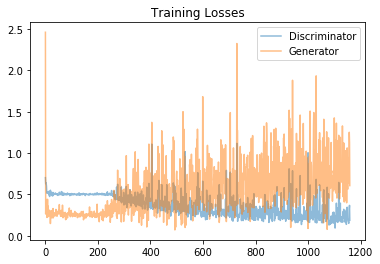

In [29]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [30]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [31]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

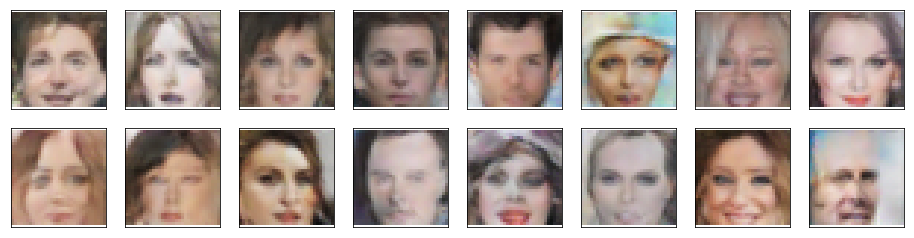

In [32]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

* The training dataset is indeed biased against black celebrities thus generating racially unbalanced images
* Deeper CNN networks are able to capture finer details and therefore, at the expense of training resources, the deeper the model the better the performance
* As the number of epochs increased, the generator loss trickled upwards while the discriminator’s ability to detect fake images kept on getting better. The generator seemed to be overfitting/ memorizing the input examples and deduplication strategy as discussed in the original DCGAN paper could have helped improve the model 
* Further hyperparameter optimization would indeed improve the model


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.